<a href="https://colab.research.google.com/github/reznimat/ppzd_sp/blob/main/semestralni_prace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Načtení knihoven

In [2]:
import csv
import pandas as pd
import math as mt
import datetime as dt
from matplotlib import pyplot as plt

# Definice funkcí

In [26]:
# funkce pro výpočet sales_amount po slevě na úrovni item
# není zohledněna doprava
def RowTotal(row):
    if row["Coupon_Status"] == 'Not Used':
      return (row["Quantity"]*row["Avg_Price"])*(1+(row["GST_pct"]/100))
    else:
      return (row["Quantity"]*row["Avg_Price"])*(1+(row["GST_pct"]/100))*(1-(row["Discount_pct"]/100))

# Načtení datových souborů

In [21]:
# POZOR, pouze vzorek dat
#url_sales = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/SAMPLE_Online_Sales.csv'
url_sales = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Online_Sales.csv'
df_sales = pd.read_csv(url_sales)

url_coupons = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Discount_Coupon.csv'
df_coupons = pd.read_csv(url_coupons,sep=";")

url_tax = 'https://raw.githubusercontent.com/reznimat/ppzd_sp/main/Tax_amount.csv' #původní GST ve formátu 10% ručně upraveno na GST_pct ve formátu 10 (18 položek)
df_tax = pd.read_csv(url_tax,sep=";")

#dict_sales = df_sales.to_dict('records')

print('**Sales**')
print(df_sales.info())
print('\n------\n')
print('**Coupons**')
print(df_coupons.info())
print('\n------\n')
print('**Tax**')
print(df_tax.info())



**Sales**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB
None

------

**Coupons**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----

# Calculate Invoice amount or sale_amount or revenue for each transaction and item level

 - Hint: InvoiceValue = (( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges


## Obohacení df_sales o atribut Month (Date Abrv)

In [22]:
# Obohacení df_sales o Month pole
def MonthAbrv(row):
    return pd.to_datetime(row.Transaction_Date,format='%m/%d/%Y').strftime("%b")

df_sales['Month'] = df_sales.apply(MonthAbrv, axis=1)

#print(df_sales.info())

## Spojení sales a coupons tabulek přes Product_Category a Month

In [23]:
#Merge Sales a Coupons na základě Product Category a Month
df_sales_coupons = pd.merge(df_sales,df_coupons, on=["Product_Category","Month"])
df_sales_coupons_tax = pd.merge(df_sales_coupons,df_tax, on=["Product_Category"])

#print(df_sales_coupons.info())
print(df_sales_coupons_tax.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52524 entries, 0 to 52523
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52524 non-null  int64  
 1   Transaction_ID       52524 non-null  int64  
 2   Transaction_Date     52524 non-null  object 
 3   Product_SKU          52524 non-null  object 
 4   Product_Description  52524 non-null  object 
 5   Product_Category     52524 non-null  object 
 6   Quantity             52524 non-null  int64  
 7   Avg_Price            52524 non-null  float64
 8   Delivery_Charges     52524 non-null  float64
 9   Coupon_Status        52524 non-null  object 
 10  Month                52524 non-null  object 
 11  Coupon_Code          52524 non-null  object 
 12  Discount_pct         52524 non-null  int64  
 13  GST_pct              52524 non-null  int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 5.6+ MB
None


## Počet a výpis jedinečných produktových kategorií

In [24]:
# Počet a výpis distinktních produktových kategorií
uniqPC = set()
for i, row in df_sales.iterrows():
  uniqPC.add(row["Product_Category"])

print("Produktových kategorií: "+ str(len(uniqPC)) )  # vypíše počet produktových kategorií
print(uniqPC)  # vypíše seznam produktových kategorií

Produktových kategorií: 20
{'Android', 'Gift Cards', 'Apparel', 'Housewares', 'Headgear', 'Bottles', 'Nest-Canada', 'Google', 'Waze', 'Accessories', 'Notebooks & Journals', 'Nest', 'Drinkware', 'Office', 'Lifestyle', 'Fun', 'Backpacks', 'More Bags', 'Nest-USA', 'Bags'}


## Obohacení sales_coupons o RowTotal

In [28]:
# nejsou započítány náklady na dopravu a daně

#def RowTotal(row):
#    if row["Coupon_Status"] == 'Not Used':
#      return row["Quantity"] * row["Avg_Price"]
#    else:
#      return (row["Quantity"] * row["Avg_Price"])*(1-(row["Discount_pct"]/100))

df_sales_coupons_tax["RowTotal"] = df_sales_coupons_tax.apply(RowTotal,axis = 1)

print(df_sales_coupons_tax)

       CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
0           17850           16679         1/1/2019  GGOENEBJ079499   
1           17850           16680         1/1/2019  GGOENEBJ079499   
2           13047           16684         1/1/2019  GGOENEBQ078999   
3           13047           16684         1/1/2019  GGOENEBQ079199   
4           13047           16688         1/1/2019  GGOENEBB078899   
...           ...             ...              ...             ...   
52519       12956           48475       12/31/2019  GGOENEBQ092299   
52520       12956           48477       12/31/2019  GGOENEBQ086799   
52521       14410           48490       12/31/2019  GGOENEBQ086799   
52522       14410           48491       12/31/2019  GGOENEBQ086799   
52523       14410           48492       12/31/2019  GGOENEBQ086799   

                                     Product_Description Product_Category  \
0      Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA   
1    

In [ ]:
Months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
#print(Months)

**Tržby po kategoriích a měsících**

In [ ]:
Month_Category_Sales = df_sales_coupons[["Transaction_Date","Month","Product_Category","RowTotal"]]

print(Month_Category_Sales)

      Transaction_Date Month Product_Category  RowTotal
0             1/1/2019   Jan         Nest-USA   138.339
1             1/1/2019   Jan         Nest-USA   138.339
2             1/1/2019   Jan         Nest-USA   220.986
3             1/1/2019   Jan         Nest-USA    73.350
4             1/1/2019   Jan         Nest-USA   110.493
...                ...   ...              ...       ...
52519       12/17/2019   Dec       Gift Cards    71.351
52520       12/19/2019   Dec       Gift Cards    35.672
52521       12/23/2019   Dec       Gift Cards   178.374
52522       12/25/2019   Dec       Gift Cards    25.480
52523       12/29/2019   Dec       Gift Cards    71.351

[52524 rows x 4 columns]


** Pokus o graf - groupby ale udělal z měsíců indexy a řadí je teď podle abecedy **

        RowTotal
Month           
Apr    80949.670
Aug    44199.104
Dec    36533.925
Feb    31479.736
Jan    35093.928
Jul    59711.047
Jun    33868.464
Mar    44846.421
May    49009.162
Nov    15374.506
Oct    19861.988
Sep    41633.391


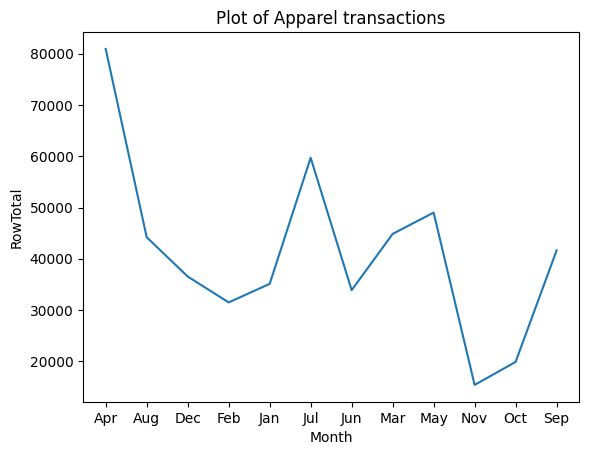

In [ ]:
df=Month_Category_Sales

# Specify categories to plot
categories_to_plot = ['Apparel']

# Filter data for desired categories
filtered_data = df[df['Product_Category'].isin(categories_to_plot)]

plot_input=filtered_data.groupby('Month').sum('RowTotal')
#plot_input['month_datetime'] = pd.to_datetime(plot_input.index)

print(plot_input)

#plot_input = plot_input.set_index('month_datetime')
#plot_input = plot_input.sort_index()



# Create your plot (replace with your desired plot type)

plt.plot(plot_input.index, plot_input["RowTotal"])
plt.xlabel('Month')
plt.ylabel('RowTotal')
plt.title('Plot of Apparel transactions')
plt.show()

** Funkční (ale nekonečný) výpočet měsíčních prodejů po kategoriích **

In [ ]:
my_list = []

for kategorie in uniqPC:
  for mesic in Months:
    CategorySales = 0
    for i, row in df_sales_coupons.iterrows():
      if row.Product_Category == kategorie and row.Month == mesic:
        if row.Coupon_Status =='Not Used':
          CategorySales += (row.Quantity*row.Avg_Price) # Bez slevy
        else:
          CategorySales += (row.Quantity*row.Avg_Price)*(1-(row.Discount_pct/100)) # Se slevou
    my_list.append((kategorie, mesic, CategorySales)) # append vypočítaný záznam do listu
#    print()
#    slovnik["kategorie"] = kategorie
#    slovnik["mesic"] = mesic
#    slovnik["Sales"] = CategorySales

df_CatMonSales = pd.DataFrame.from_records(my_list, columns=['kategorie', 'mesic','Sales']) # převod listu na data_frame

print(df_CatMonSales)

     kategorie mesic    Sales
0    More Bags   Jan    0.000
1    More Bags   Feb    0.000
2    More Bags   Mar    0.000
3    More Bags   Apr    0.000
4    More Bags   May    0.000
..         ...   ...      ...
235       Waze   Aug  458.282
236       Waze   Sep  229.867
237       Waze   Oct  440.034
238       Waze   Nov  858.362
239       Waze   Dec  477.472

[240 rows x 3 columns]


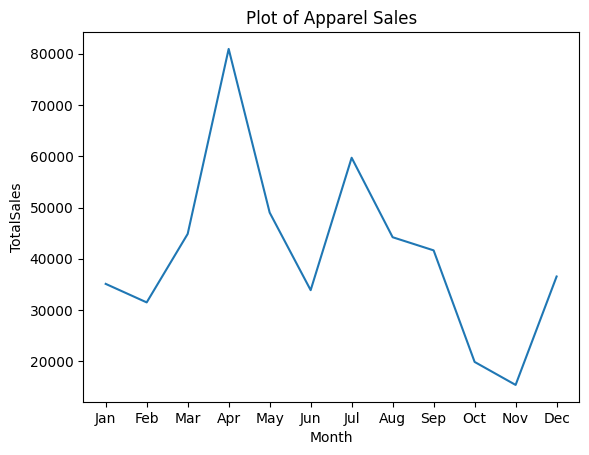

In [ ]:
df=df_CatMonSales

# Specify categories to plot
categories_to_plot = ['Apparel']

# Filter data for desired categories
filtered_data = df[df['kategorie'].isin(categories_to_plot)]

# Create your plot (replace with your desired plot type)

plt.plot(filtered_data["mesic"], filtered_data["Sales"])
plt.xlabel('Month')
plt.ylabel('TotalSales')
plt.title('Plot of Apparel Sales')
plt.show()